<a href="https://colab.research.google.com/github/ishandahal/image_segmentation/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fully Connected Network with Resnet-101 background

In [2]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


We have downloaded a pretrained model

Getting an image

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png

2021-01-18 17:27:28 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


In [4]:
!wget -nv https://upload.wikimedia.org/wikipedia/commons/6/6d/Stoned_Fox_.jpg -O dog.png

2021-01-18 17:27:28 URL:https://upload.wikimedia.org/wikipedia/commons/6/6d/Stoned_Fox_.jpg [815532/815532] -> "dog.png" [1]


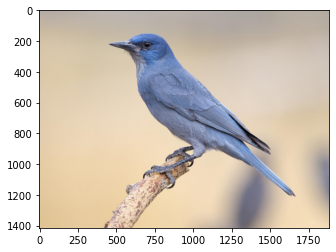

In [5]:
img = Image.open('/content/bird.png')
plt.imshow(img);
plt.show()

#### Preprocessing the image
- Resize the image to (256 x 256)
- Center crop image to (224 x 224)
- Convert it to Tensor (values will be between [0, 1])
- Normalize using Imagenet values of mean and std

In [6]:
import torchvision.transforms as T

In [7]:
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

# add bath dimension and after transform
inp = trf(img).unsqueeze(0)

In [8]:
print(inp.size())

torch.Size([1, 3, 224, 224])


Output of the model is an ordered dict with `out` key

In [9]:
out = fcn(inp)['out']
print(out.size())

torch.Size([1, 21, 224, 224])


Dimension 1 represents the number of classes in the model

In [49]:
import numpy as np
output = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print(output.shape)
print(np.unique(output))

(224, 224)
[0 3]


In [11]:
## helper function to return the output

def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

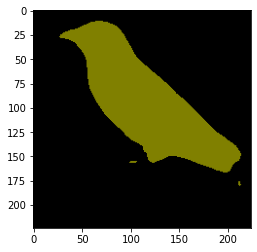

In [12]:
rgb = decode_segmap(output)
plt.imshow(rgb);
plt.show()

This is a segment of the bird. The image appears larger because we center cropped and resized the image.
Let's create a function that does it all

In [13]:
def segment(model, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    trf = T.Compose([T.Resize(640),
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    input = trf(img).unsqueeze(0).to(dev)
    out = model.to(dev)(input)['out']
    output = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(output)
    plt.imshow(rgb); plt.axis('off'); plt.show()

Using it on a dog image

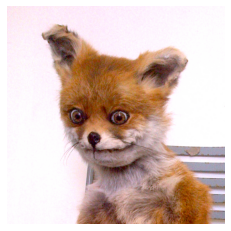

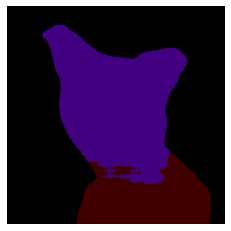

Using fully connected networl


In [14]:
segment(fcn, '/content/dog.png')
print('Using fully connected networl')

Using DeepLabv3

DeepLabv3

In [15]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


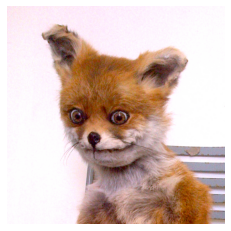

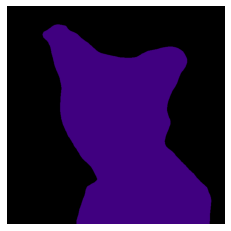

Using dlabv3


In [16]:
segment(dlab, '/content/dog.png')
print('Using dlabv3')

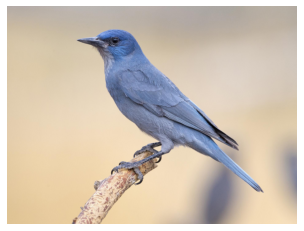

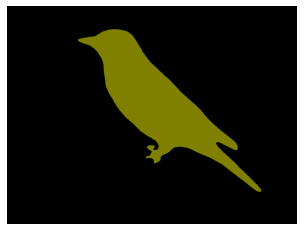

dlabv3


In [17]:
segment(dlab, '/content/bird.png')
print('dlabv3')

In [18]:
!wget -nv https://upload.wikimedia.org/wikipedia/commons/6/65/Team_Work.jpg -O group.png

2021-01-18 17:27:47 URL:https://upload.wikimedia.org/wikipedia/commons/6/65/Team_Work.jpg [1040899/1040899] -> "group.png" [1]


Image segmentation with FCN


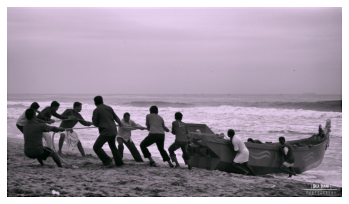

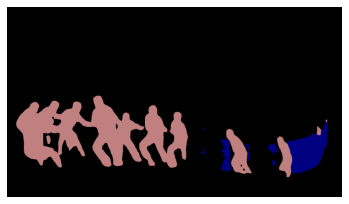

In [19]:
print('Image segmentation with FCN')
segment(fcn, '/content/group.png')


Image segmentation with dlabv3


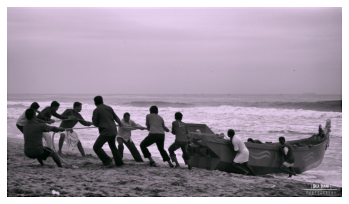

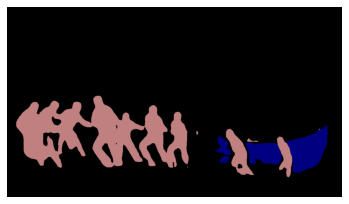

In [20]:
print('Image segmentation with dlabv3')
segment(dlab, '/content/group.png')